<a href="https://colab.research.google.com/github/lionadis/Easy21/blob/master/Easy21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
from numpy.random import choice, rand
from enum import Enum
from copy import copy
from collections import defaultdict
from tqdm import tqdm as tqdm
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

In [0]:
class State:
  def __init__(self, player=0, dealer=0, is_terminated=False):
    self.player = player
    self.dealer = dealer
    self.is_terminated = is_terminated
  
  def tuple(self):
    return (self.player, self.dealer)
  
  def __repr__(self):
    return "({}, {})".format(self.player, self.dealer)

In [0]:
class Action(Enum):
  HIT = 0
  STICK = 1
  
  @staticmethod
  def get_actions():
    return [Action.HIT, Action.STICK]

In [0]:
class Player:

  def action(self, s):
    raise Exception("Needs to be implemented")

In [0]:
class RandomPlayer(Player):
  def action(self, s):
    return choice(Action.get_actions())

In [0]:
class Dealer:
  def action(self, s):
    return Action.HIT if s.dealer < 17 else Action.STICK

In [0]:
class Easy21Env:

  def __init__(self, dealer):
    self.dealer = dealer
  
  def step(self, s, a):
    if s.is_terminated:
      print("Can't take any actions, Game is over")
      return s, 0
    next_s = copy(s)
    if a == Action.HIT:
      next_s.player += self._deal()
      next_s.is_terminated = self._check_bust(next_s.player)
    else:
      while(not next_s.is_terminated and self.dealer.action(next_s) == Action.HIT):
        next_s.dealer += self._deal()
        next_s.is_terminated = self._check_bust(next_s.dealer)
      next_s.is_terminated = True
    return next_s, self._compute_reward(next_s)
  
  def _compute_reward(self, s):
    if not s.is_terminated or s.player == s.dealer:
      return 0
    if s.player > s.dealer:
      return -1 if self._check_bust(s.player) else 1
    else:
      return 1 if self._check_bust(s.dealer) else -1
    
  
  def _check_bust(self, value):
    return value <= 1 or value >= 22
  
  def _deal(self, color=None):
    value = choice(range(1, 11))
    if color:
      coef = 1 if color=='b' else -1
    else:
      coef = choice([1, -1], p=[2.0/3, 1.0/3])
    return value * coef
   
  def reset(self):
      return State(env._deal('b'), env._deal('b'))


In [177]:
env = Easy21Env(Dealer())
player = RandomPlayer()
s = env.reset()
print(s.__dict__)
while not s.is_terminated:
  action = player.action(s)
  s, reward = env.step(s, action)
  print(action)
  print(s.__dict__)
  print(reward)

{'player': 9, 'dealer': 3, 'is_terminated': False}
Action.STICK
{'player': 9, 'dealer': 21, 'is_terminated': True}
-1


#Monte-Carlo Control

Repeat forever

1.   Sample the k-th episode using $\pi_t$, $\{S_1,A_1,R_2,.....,S_T\} \sim \pi_t $
2.   $\forall(S_t,A_t)$:
  *   $N(S_t,A_t) \leftarrow N(S_t,A_t) + 1$
  *   $Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \frac{1}{N(S_t,A_t)}(G_t - Q(S_t,A_t))$
3.   $\pi_{t+1} \leftarrow \epsilon{\text -}greedy(Q)$







In [0]:
def plot_value_function(title, v):
  x = np.arange(1, 22)
  y = np.arange(1, 11)
  X, Y = np.meshgrid(x, y)
  def f(x, y):
    xy = np.dstack((x, y))
    res = np.zeros((xy.shape[:2]))
    for i in np.ndindex(xy.shape[:2]):
      res[i] = v[tuple(xy[i])]
    return res
  Z = f(X, Y)
  fig = fig = plt.figure(title, figsize=(10, 5))
  ax = plt.axes(projection='3d')
  ax.plot_surface(Y, X, Z, cmap='viridis')
  ax.set_xlabel('dealer sum')
  ax.set_ylabel('player sum')
  ax.set_zlabel('potential reward')

In [0]:
class MCAgent(Player):
  def __init__(self, N0=100,gamma=1):
    self.Q = defaultdict(int) #creates a dict with a dictionnary with a default value of 0
    self.N = defaultdict(int) # number of time the pair (s, a) is visited
    self.N0 = N0
    self.gamma = gamma # discount factor
    
  def action(self, s):
    '''
      compute the number of times we visisted state s
      N(S) = sum N(s,a) for all a in actions
    '''
    N_total = 0
    actions = Action.get_actions()
    for action in actions:
      N_total += self.N[(s.tuple(), action)]
    '''
      choose a random action with eps probability
    '''
    eps = 1.0 * self.N0 / (self.N0 + N_total)
    if rand() <= eps:
      return choice(actions)
    '''
      else pick the best action, argmax_a Q[(s, a)]
    '''
    best_action, best_value = None, -1e9
    for action in actions:
      if best_value < self.Q[(s.tuple(), action)]:
        best_action, best_value = action, self.Q[(s.tuple(), action)]
    return best_action
  
  def learn(self, h):
    '''
      h: the history of an episode
    '''
    h = h[::-1]
    g_t = 0
    for (s, a, r) in h:
      g_t += r
      self.N[(s.tuple(), a)] += 1
      self.Q[(s.tuple(), a)] += 1.0 / self.N[(s.tuple(),a)] * (g_t - self.Q[(s.tuple(), a)])
  
  def value_function(self):
    v = defaultdict(lambda:-1e9)
    for (s, a), q in self.Q.items():
      v[s] = max(v[s], q)
    return v

In [248]:
def monte_carlo_control(num_episodes=1000000):
  agent = MCAgent()
  wins = 0
  for episode in range(num_episodes):
    env = Easy21Env(Dealer())
    s = env.reset()
    h = [] # history
    while not s.is_terminated:
      a = agent.action(s)
      next_s, r = env.step(s, a)
      h.append((s, a, r))
      s = next_s
    wins += (h[-1][2] == 1)
    agent.learn(h)
    if(episode % 10000 == 0):
      print("episode {} winrate {}".format(episode, 1.0 * wins / (episode + 1)))
  return agent
agent = monte_carlo_control()

episode 0 winrate 0.0
episode 10000 winrate 0.4834516548345166
episode 20000 winrate 0.4975251237438128
episode 30000 winrate 0.501616612779574
episode 40000 winrate 0.5063873403164921
episode 50000 winrate 0.509429811403772
episode 60000 winrate 0.509724837919368
episode 70000 winrate 0.5110355566349052
episode 80000 winrate 0.5130935863301709
episode 90000 winrate 0.513416517594249
episode 100000 winrate 0.5148048519514805
episode 110000 winrate 0.5156134944227779
episode 120000 winrate 0.5166623611469905
episode 130000 winrate 0.5177190944685041
episode 140000 winrate 0.5183034406897093
episode 150000 winrate 0.5196165358897608
episode 160000 winrate 0.5200154999031256
episode 170000 winrate 0.5206851724401621
episode 180000 winrate 0.520769329059283
episode 190000 winrate 0.5217551486571124
episode 200000 winrate 0.5222323888380558
episode 210000 winrate 0.5227546535492689
episode 220000 winrate 0.5232067126967604
episode 230000 winrate 0.5233542462858857
episode 240000 winrate 0.5

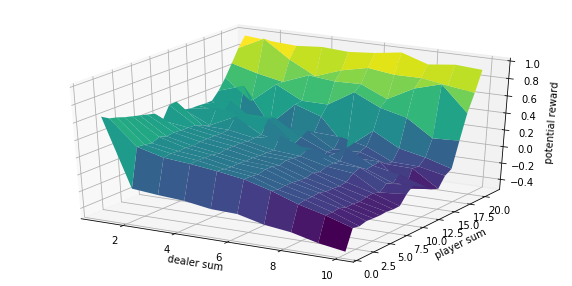

In [249]:
plot_value_function("MC ", agent.value_function())